In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
PATH = Path('/home/sean/hpc-home/skin_cancer/ISIC')

trn_p = PATH / 'Part3_train_gt.csv'
val_p = PATH / 'Part3_val_gt.csv'
imgd = PATH / 'ISIC-2017_Training_Data'
vimgd = PATH / 'ISIC-2017_Validation_Data'
test_folder = 'ISIC-2017_Test_v2_Data_Classification/'
test_lbls = PATH / 'isic17_p3_test_gt.csv'

train_csv = PATH / 'train.csv' # created in this script
val_csv = PATH / 'val_isic17.csv'
test_csv = PATH / 'test_isic17.csv'

PATH.exists(), trn_p.exists(), val_p.exists(), imgd.exists(), (PATH / test_folder).exists(), vimgd.exists()

(True, True, True, True, True, True)

In [3]:
%ls $PATH

classification/                            models/
isic17_p3_test_gt.csv*                     Part3_train_gt.csv*
ISIC-2017_Test_v2_Data/                    Part3_val_gt.csv*
ISIC-2017_Test_v2_Data_Classification/     test_isic17.csv*
ISIC-2017_Test_v2_Data_metadata.csv*       test_seg_isic17_data*
ISIC-2017_Test_v2_Part1_GroundTruth/       test_seg_isic17_gt*
ISIC-2017_Test_v2_Part3_GroundTruth.csv*   tmp/
ISIC-2017_Training_Data/                   train.csv*
ISIC-2017_Training_Part1_GroundTruth/      train_val_comb.csv*
ISIC-2017_Training_Part1_GroundTruth.zip*  val_isic17.csv*
ISIC-2017_Validation_Data/                 valset_download*
ISIC-2017_Validation_Part1_GroundTruth/    valset_gt_download*


## Process CSV for FastAI API

The process for formatting the CSV labels is different for all datasets, so no standard functions. Might have to load labels into a CSV for other datasets (not hard with pandas - pd).

In [6]:
# This will only work for ISIC2017 part 3 
def isic_label_proc(csvn, outcsv):
    df = pd.read_csv(csvn)
    df.set_index('image_id', inplace=True)
    # get classes
    mel_id = np.array(df['melanoma']) == 1
    classes = np.zeros(mel_id.shape).astype(str)
    classes[mel_id] = 'melanoma'

    sk_id = np.array(df['seborrheic_keratosis']) == 1
    assert np.intersect1d(np.where(mel_id), np.where(sk_id)).shape[0] == 0
    classes[sk_id] = 'seborrheic_keratosis'
    classes[classes == '0.0'] = 'nevus'
    df['classes'] = classes
    
    dfset = df[['classes']].copy()
    dfset['classes'].value_counts().plot(kind='barh')
    dfset.to_csv(outcsv)
    return dfset

# trn_csv = isic_label_proc(trn_p, train_csv)
# trn_csv.head()
# val_csv = isic_label_proc(val_p, val_csv)

classes
image_id            
ISIC_0001769   nevus
ISIC_0001852   nevus
ISIC_0001871   nevus
ISIC_0003462   nevus
ISIC_0003539   nevus
ISIC_0003582   nevus
ISIC_0003657   nevus
ISIC_0003805   nevus
ISIC_0004337   nevus
ISIC_0006651   nevus
ISIC_0006671   nevus
ISIC_0006815   nevus
ISIC_0006914   nevus
ISIC_0007141   nevus
ISIC_0007156   nevus
ISIC_0007235   nevus
ISIC_0007241   nevus
ISIC_0007332   nevus
ISIC_0007344   nevus
ISIC_0007528   nevus

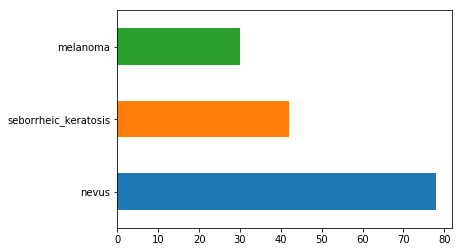

In [7]:
valdf = isic_label_proc(val_p, val_csv)
valdf.head(20)

classes
image_id                          
ISIC_0012086  seborrheic_keratosis
ISIC_0012092                 nevus
ISIC_0012095                 nevus
ISIC_0012134  seborrheic_keratosis
ISIC_0012136  seborrheic_keratosis

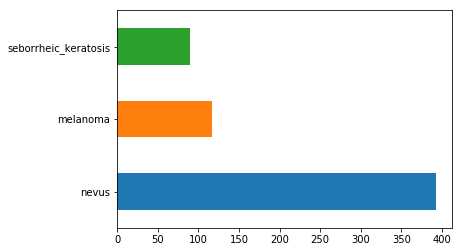

In [13]:
test_df = isic_label_proc(test_lbls, test_csv)
test_df.head()

In [63]:
imgd.name, vimgd.name

('ISIC-2017_Training_Data', 'ISIC-2017_Validation_Data')

### Combine Train and Validation Sets into Training Scheme

In [68]:
tdf = pd.read_csv(train_csv)
tdf['image_id'] = str(imgd.name) + '/' + np.array(tdf['image_id'])
vdf = pd.read_csv(val_csv)
vdf['image_id'] = str(vimgd.name) + '/' + np.array(vdf['image_id'])

150 2000


((2150, 2), <matplotlib.axes._subplots.AxesSubplot at 0x7f02ea4851d0>)

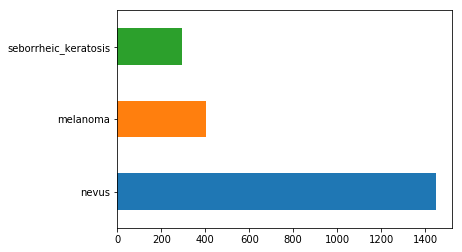

In [69]:
lvdf, ltdf = len(vdf), len(tdf)
print(lvdf, ltdf)
comb_df = pd.concat([tdf, vdf])
comb_df.shape, comb_df['classes'].value_counts().plot(kind='barh')

In [70]:
val_idx = list(range(ltdf, len(comb_df)))
all(comb_df.iloc[val_idx, :] == vdf)

True

In [75]:
comb_csv = PATH / 'train_val_comb.csv'
comb_df.set_index('image_id', inplace=True)
comb_df.to_csv(comb_csv)

## Data Loaders

In [77]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=resnet34
# image size
sz=224
bs=64

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, '', comb_csv, tfms=tfms,
                    suffix='.jpg', bs=bs, test_name=test_folder, val_idxs=val_idx)

In [78]:
data.classes

['melanoma', 'nevus', 'seborrheic_keratosis']

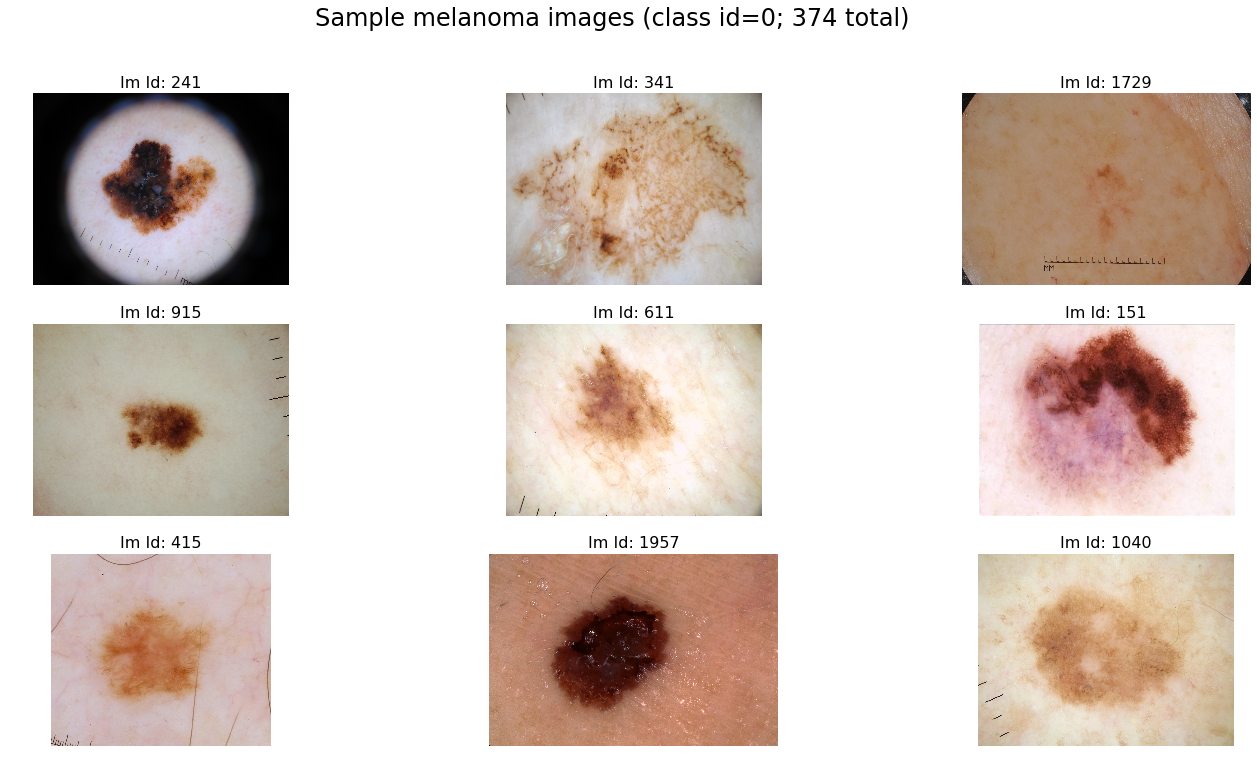

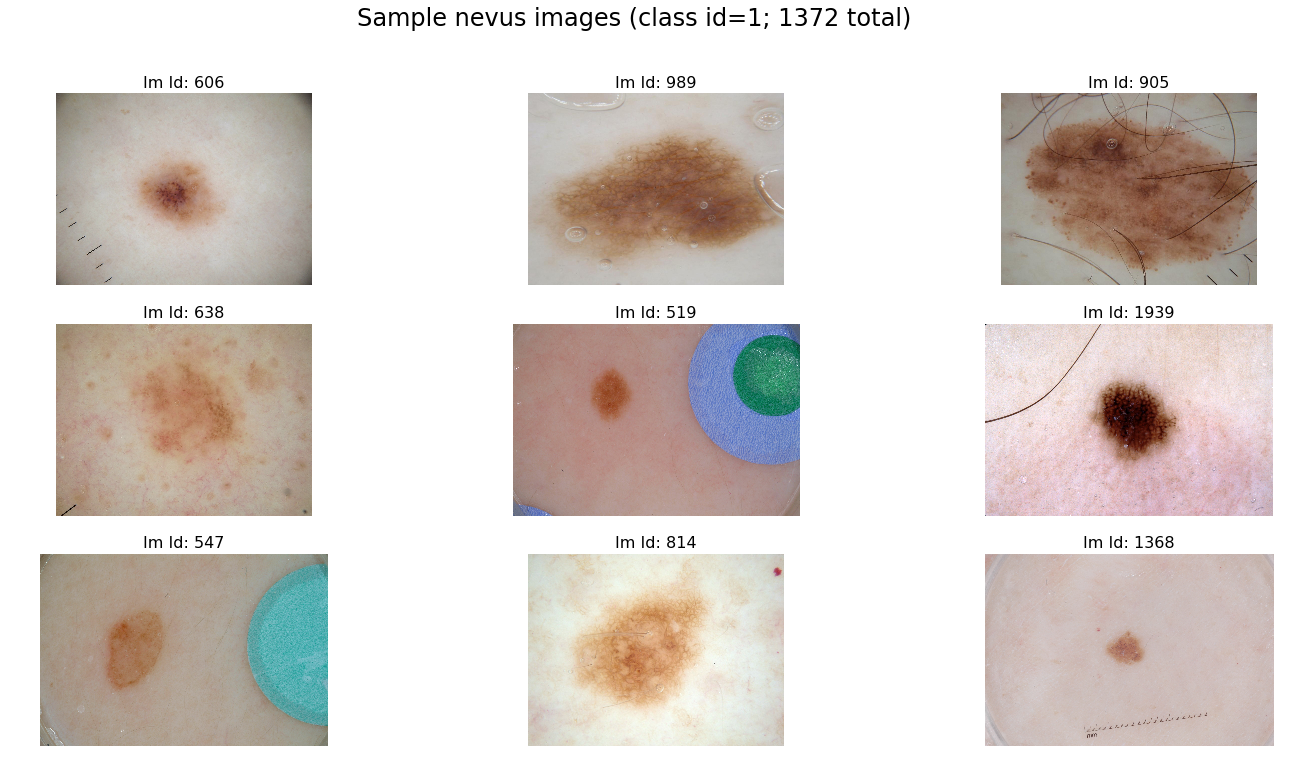

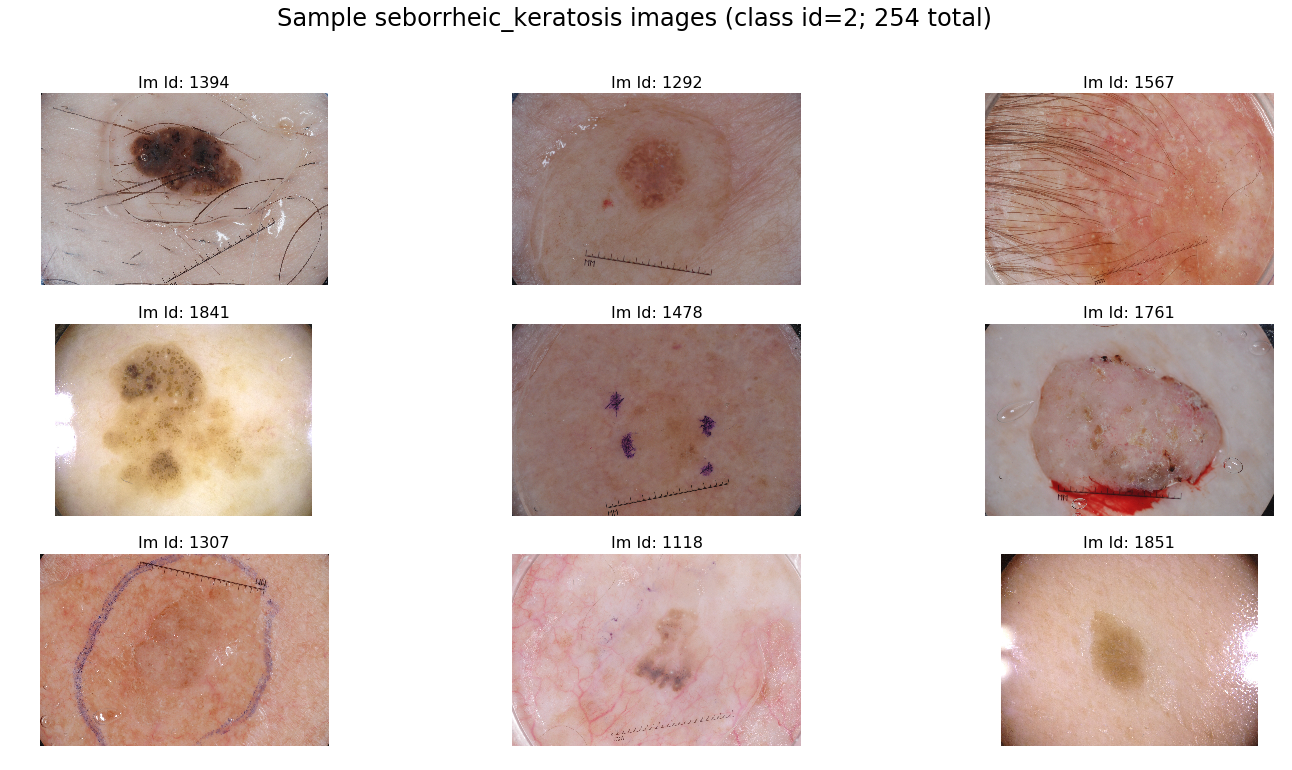

In [80]:
for i in range(min(len(data.classes),10)): sample_ims(PATH, i, data)

# Setup and Train Network

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('isic17_part3_2')

In [81]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 10/10 [02:07<00:00, 12.70s/it]


This can be used to help find the inital learning rate. 

In [82]:
lrf=learn.lr_find()
# learn.sched.plot_lr()

 78%|███████▊  | 25/32 [00:02<00:00,  8.52it/s, loss=1.34]


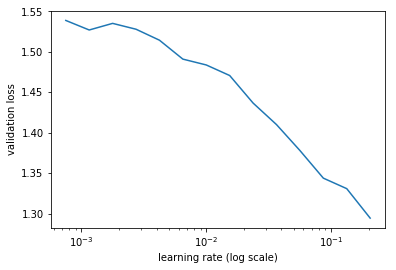

In [83]:
learn.sched.plot()

In [84]:
learn.fit(9e-2, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.243071   1.716577   0.573333  
    1      1.270719   1.351877   0.613333                 
    2      1.090931   1.194528   0.586667                 



[array([1.19453]), 0.5866666674613953]

In [85]:
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.660865   0.886773   0.64      
    1      0.638066   0.919988   0.686667                  
    2      0.621053   0.856234   0.686667                  
    3      0.593167   0.850207   0.686667                  



[array([0.85021]), 0.6866666674613953]

In [86]:
learn.save('isic17_part3_train_val_1')

In [ ]:
learn.load('isic17_part3_train_val_1')

 97%|█████████▋| 31/32 [01:25<00:02,  2.75s/it, loss=2.71] 

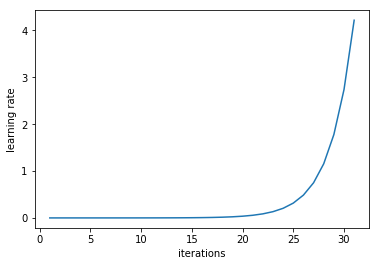

In [87]:
learn.precompute = False
lrf=learn.lr_find()
learn.sched.plot_lr()

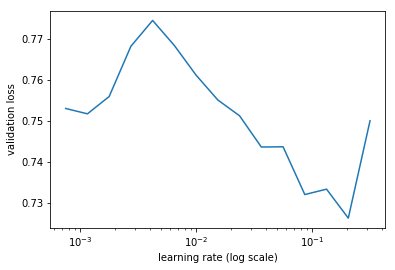

In [88]:
learn.sched.plot()

In [90]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.690629   0.827197   0.64      
    1      0.674848   0.808509   0.673333                  
    2      0.664199   0.814939   0.653333                  
    3      0.659675   0.807414   0.666667                  
    4      0.647753   0.78599    0.68                      
    5      0.640794   0.797159   0.68                      
    6      0.630558   0.79561    0.666667                  


[array([0.79561]), 0.6666666698455811]

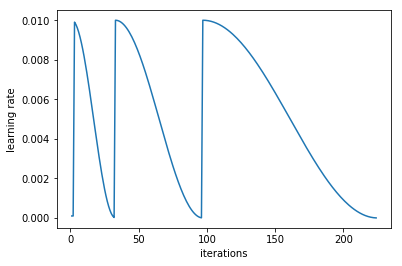

In [91]:
learn.sched.plot_lr()

In [93]:
learn.save('isic17_part3_train_val_2')

In [ ]:
learn.load('isic17_part3_train_val_2')

 97%|█████████▋| 31/32 [01:48<00:03,  3.51s/it, loss=0.852]

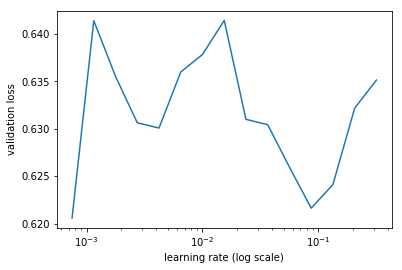

In [94]:
lrf=learn.lr_find()
learn.sched.plot()

In [95]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.772652   0.720261   0.68      
    1      0.698477   0.704698   0.706667                  
    2      0.657925   0.709505   0.666667                  
    3      0.634584   0.699848   0.72                      
    4      0.602199   0.684161   0.693333                  
    5      0.566823   0.663613   0.706667                  
    6      0.541979   0.665726   0.706667                  


[array([0.66573]), 0.7066666674613953]

In [96]:
learn.save('isic17_part3_train_val_3')

In [97]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 8, cycle_len=3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.533294   0.653918   0.713333  
    1      0.509725   0.627147   0.726667                  
    2      0.497452   0.62612    0.74                      
    3      0.487433   0.60729    0.733333                  
    4      0.478015   0.617849   0.72                      
    5      0.468284   0.642974   0.726667                  
    6      0.459531   0.631823   0.746667                  
    7      0.439673   0.625933   0.74                      
    8      0.425738   0.62402    0.74                      
    9      0.426298   0.602982   0.753333                  
    10     0.418716   0.597502   0.746667                  
    11     0.404096   0.590024   0.746667                  
    12     0.388172   0.585722   0.753333                  
    13     0.378918   0.577245   0.76                      
    14     0.367483   0.599259   0.74                      
    15     0.373909   0.562376   0.773333               

[array([0.58293]), 0.7533333341280619]

In [98]:
learn.save('isic17_part3_train_val_4')

In [101]:
wd=1e-5
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.270589   0.572949   0.793333  
    1      0.261926   0.610385   0.746667                  
    2      0.243581   0.61263    0.74                      
    3      0.259808   0.631782   0.746667                  
    4      0.258328   0.634572   0.773333                  
    5      0.246453   0.587321   0.793333                  
    6      0.230344   0.596343   0.786667                  
    7      0.217104   0.617487   0.773333                  
    8      0.23091    0.673473   0.773333                  
    9      0.228651   0.69736    0.766667                  
    10     0.211236   0.636966   0.786667                  
    11     0.194564   0.650019   0.766667                  
    12     0.200521   0.640673   0.773333                  
    13     0.184674   0.713465   0.773333                  
    14     0.170782   0.694996   0.773333                  
    15     0.158498   0.725387   0.78                   

[array([0.69135]), 0.7666666634877523]

In [ ]:
learn.save('isic17_part3_train_val_3')

# Evaluations and Visualisations

Accuracy = 0.82                              
Confusion Matrix:
[[13 14  3]
 [ 4 72  2]
 [ 0  4 38]]
AUC for class 0, id melanoma = 0.85
AUC for class 1, id nevus = 0.93
AUC for class 2, id seborrheic_keratosis = 0.98
----------------------------------------
[[13 14  3]
 [ 4 72  2]
 [ 0  4 38]]


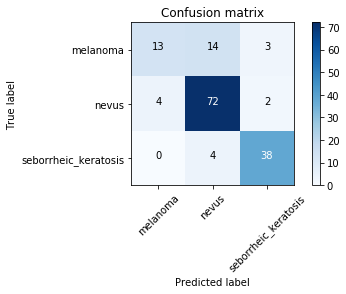

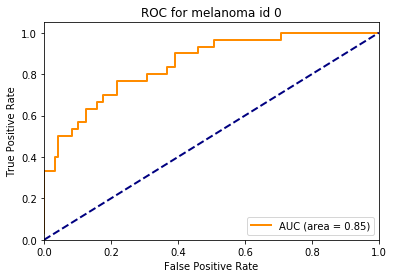

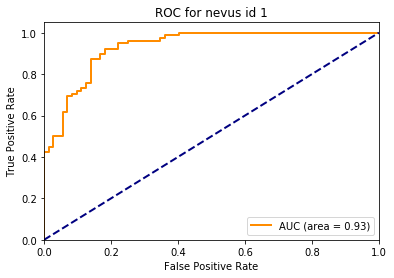

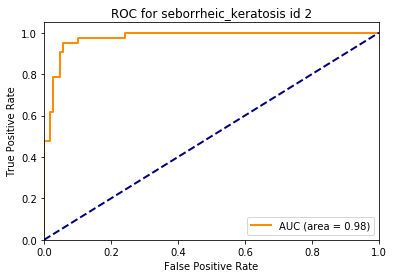

In [99]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn, sf=True)

Text(0.5,1,'Val network predictions distribution')

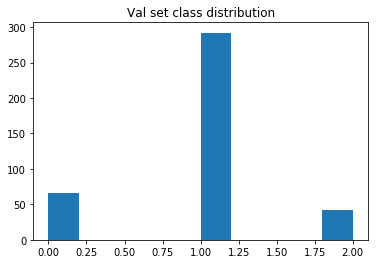

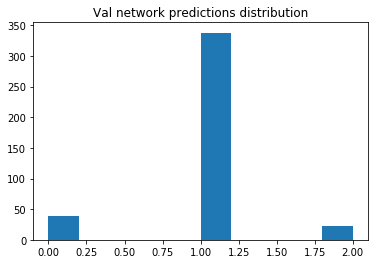

In [84]:
plt.hist(vy, align='mid')
plt.title('Val set class distribution')
plt.figure()
plt.hist(vf_preds, align='mid')
plt.title('Val network predictions distribution')

In [96]:
logpr = learn.predict()
preds = np.argmax(np.exp(logpr), axis=1)

In [100]:
probs = logpr[np.arange(logpr.shape[0]), preds]
probs.shape, logpr.shape

((400,), (400, 3))

In [ ]:
def visualise(learner, d):
    logpr = learner.predict()
    preds = np.argmax(np.exp(logpr), axis=1)
    probs = logpr[np.arange(logpr.shape[0]), preds]
    plot_val_with_title(d, probs,preds, rand_by_correct(True, preds, d.val_y), "Correctly classified")
    plot_val_with_title(d, probs,preds, rand_by_correct(False, preds, d.val_y), "Incorrectly classified")
    for i, c in enumerate(d.classes):
        plot_val_with_title(d, probs,preds, most_by_correct(i, True, preds, probs, d.val_y), "Most correct {}".format(c))
    

Correctly classified
Incorrectly classified
Most correct melanoma
Most correct nevus
Most correct seborrheic_keratosis


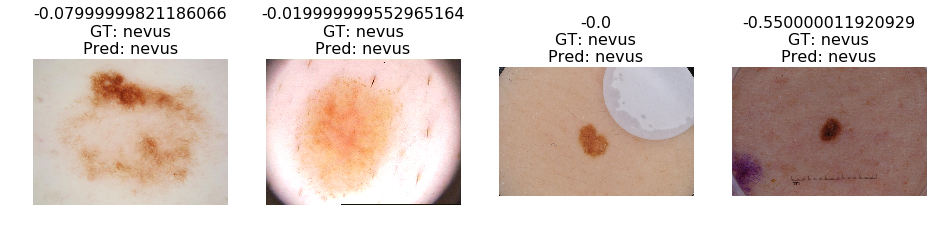

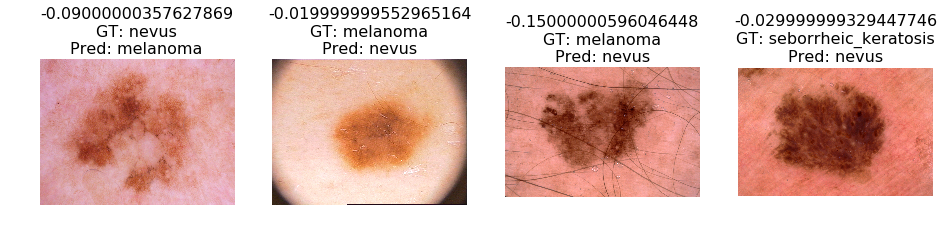

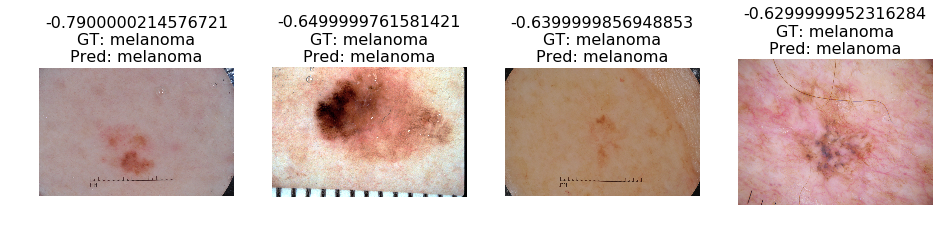

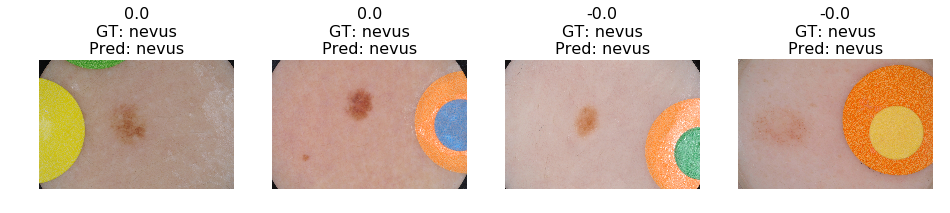

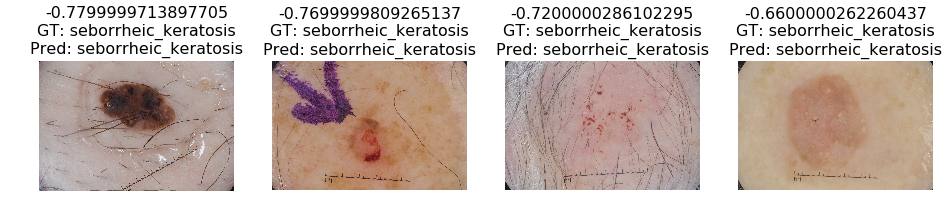

In [104]:
visualise(learn, data)

## Testset ISIC 2017

Loading ys from csv; shape (600,); vals [0 1 2]
Accuracy = 0.47
Confusion Matrix:
[[ 18  73  26]
 [ 71 251  71]
 [ 17  59  14]]
AUC for class 0, id melanoma = 0.47
AUC for class 1, id nevus = 0.50
AUC for class 2, id seborrheic_keratosis = 0.47
----------------------------------------
[[ 18  73  26]
 [ 71 251  71]
 [ 17  59  14]]


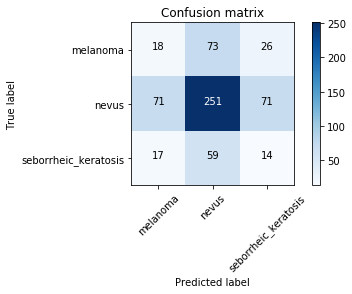

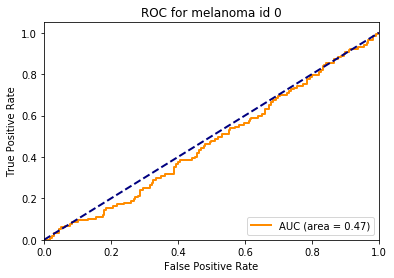

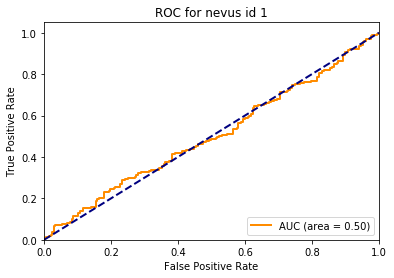

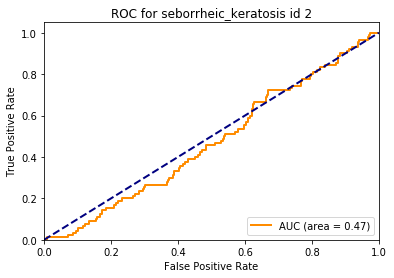

In [100]:
tf_preds, ty, tacc, tcm, troc_auc, tfpr, ttpr =run_test(learn, ts=True, sf=True, test_csv=test_csv)

Text(0.5, 1.0, 'Test network predictions distribution')

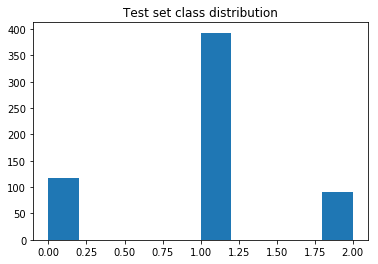

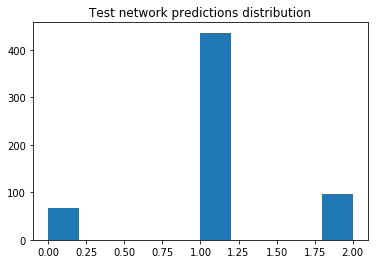

In [21]:
plt.hist(ty, align='mid')
plt.title('Test set class distribution')
plt.figure()
plt.hist(tf_preds, align='mid')
plt.title('Test network predictions distribution')